In [2]:
#Habilitar si usas google colab

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd

# Lectura de la data

In [31]:
# Utilizando google colab Jesus
#data = pd.read_csv('/content/drive/MyDrive/IA/PracticaCalificada2-CC421/train.csv', chunksize=42000000)
# Utilizando google colab Franz
data = pd.read_csv('/content/drive/MyDrive/IA_PC2/train.csv', chunksize=10000000, index_col=0)
# Desde local (jupyter notebook)
#data = pd.read_csv('train.csv', chunksize=4200000)

In [32]:
df = data.get_chunk() 

In [33]:
print(df.head())

                               fare_amount  ... passenger_count
key                                         ...                
2009-06-15 17:26:21.0000001            4.5  ...               1
2010-01-05 16:52:16.0000002           16.9  ...               1
2011-08-18 00:35:00.00000049           5.7  ...               2
2012-04-21 04:30:42.0000001            7.7  ...               1
2010-03-09 07:51:00.000000135          5.3  ...               1

[5 rows x 7 columns]


# Preprocesamiento de la data

Se cuentan las filas con valores nulos, como estás representan una cantidad infíma
simplemente se eliminarán

In [34]:
print(df.isnull().sum())

fare_amount           0
pickup_datetime       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude    69
dropoff_latitude     69
passenger_count       0
dtype: int64


In [35]:
df.dropna(inplace = True)
print(df.isnull().sum())

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [36]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

In [37]:
df['pickup_hour'] =df['pickup_datetime'].dt.hour

In [38]:
print(df['pickup_hour'])

key
2009-06-15 17:26:21.0000001      17
2010-01-05 16:52:16.0000002      16
2011-08-18 00:35:00.00000049      0
2012-04-21 04:30:42.0000001       4
2010-03-09 07:51:00.000000135     7
                                 ..
2012-08-12 01:18:00.000000208     1
2013-08-07 10:28:00.000000147    10
2013-10-29 08:29:00.00000082      8
2012-04-07 16:41:33.0000004      16
2010-03-30 19:27:00.00000066     19
Name: pickup_hour, Length: 9999931, dtype: int64


In [39]:
print(df['passenger_count'].value_counts())

1      6917305
2      1476610
5       707721
3       439133
4       212015
6       211867
0        35263
208          9
9            3
7            2
129          1
51           1
49           1
Name: passenger_count, dtype: int64


In [40]:
df.loc[df.passenger_count > 7, 'passenger_count'] = 7

In [41]:
print(df['passenger_count'].value_counts())

1    6917305
2    1476610
5     707721
3     439133
4     212015
6     211867
0      35263
7         17
Name: passenger_count, dtype: int64


In [42]:
print(df.dtypes)
print(df.head())

fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
pickup_hour                   int64
dtype: object
                               fare_amount  ... pickup_hour
key                                         ...            
2009-06-15 17:26:21.0000001            4.5  ...          17
2010-01-05 16:52:16.0000002           16.9  ...          16
2011-08-18 00:35:00.00000049           5.7  ...           0
2012-04-21 04:30:42.0000001            7.7  ...           4
2010-03-09 07:51:00.000000135          5.3  ...           7

[5 rows x 8 columns]


In [43]:
df.head()

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour
key,,,,,,,,
2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17
2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16
2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0
2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4
2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7


###Creando columna de distancia recorrida

Hallaremos la distancia recorrida en km para cada fila. \\
Usamos la Haversine formula, que halla la distancia entre dos puntos en una esfera dadas sus longitudes y latitudes. \\
$d = 2r \arcsin (\sqrt{\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) + \cos(\varphi_1)cos(\varphi_2)\sin^{2}(\frac{\lambda_2 - \lambda_1}{2})})$ \\
Sea $\varphi_1, \varphi_2$ latitudes y $\lambda_1, \lambda_2$ longitudes \\
referencia: https://en.wikipedia.org/wiki/Haversine_formula

Para disminuir los cálculos, lo llevaremos a ángulo doble: $\sin^{2}(\frac{\varphi_2 - \varphi_1}{2}) = \frac{1-\cos(\varphi_2 - \varphi_1)}{2}$

In [44]:
from math import cos, asin, sqrt, pi
p = pi/180
radioTierra = 6371
df["distancia_recorrida"] = df.apply(
    lambda fila: 2*radioTierra * asin(sqrt(0.5 - cos((fila.dropoff_latitude - fila.pickup_latitude) * p)/2 + cos(fila.pickup_latitude * p) * cos(fila.dropoff_latitude * p) * (1 - cos((fila.dropoff_longitude - fila.pickup_longitude) * p)) / 2)) 
, axis=1)

In [18]:
df.head(10)

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_hour,distancia_recorrida
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,17,1.030764
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,16,8.450134
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,0,1.389525
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,4,2.799270
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,7,1.999157
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45,-74.000964,40.731630,-73.972892,40.758233,1,9,3.787239
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00,-73.980002,40.751662,-73.973802,40.764842,1,20,1.555807
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00,-73.951300,40.774138,-73.990095,40.751048,1,17,4.155444
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00,-74.006462,40.726713,-73.993078,40.731628,1,13,1.253232
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00,-73.980658,40.733873,-73.991540,40.758138,2,1,2.849627


#Usando algoritmos y entrenando

Se usarán las siguientes carácteristicas


In [19]:
X = df.drop(['key','pickup_datetime','fare_amount','pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'],1)
y = df.fare_amount
print(X)

         passenger_count  pickup_hour  distancia_recorrida
0                      1           17             1.030764
1                      1           16             8.450134
2                      2            0             1.389525
3                      1            4             2.799270
4                      1            7             1.999157
...                  ...          ...                  ...
9999995                2            1             1.604023
9999996                1           10             1.113854
9999997                5            8             3.498755
9999998                1           16             3.304974
9999999                1           19             2.885319

[9999931 rows x 3 columns]


In [20]:
from sklearn.preprocessing import RobustScaler
transformer = RobustScaler(quantile_range = (0.1,0.9)).fit(X)
X = transformer.transform(X)

In [21]:
print(X)

[[  0.           3.          -1.08518101]
 [  0.           2.           6.33418865]
 [  1.         -14.          -0.72641972]
 ...
 [  4.          -6.           1.38280994]
 [  0.           2.           1.18902932]
 [  0.           5.           0.76937399]]


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [23]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
'''
reg_decision_model=DecisionTreeRegressor()
parameters={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

tuning_model=GridSearchCV(reg_decision_model,param_grid=parameters,scoring='neg_mean_squared_error',cv=3,verbose=3)
'''
regressor1 = DecisionTreeRegressor(random_state=0)
regressor2 = DecisionTreeRegressor(random_state=0, max_depth=13,
                                   max_features='auto',
                                   splitter='best')

regressor1.fit(X_train,y_train)
regressor2.fit(X_train,y_train)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=13,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=0, splitter='best')

In [ ]:
#print(tuning_model.best_params_)
#print(tuning_model.best_score_)
#{'max_depth': 9, 'max_features': 'auto', 'max_leaf_nodes': 10, 'min_samples_leaf': 5, 'min_weight_fraction_leaf': 0.1, 'splitter': 'best'}

In [25]:
y1 = regressor1.predict(X_test)
y2 = regressor2.predict(X_test)

In [26]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

print(mean_absolute_error(y_test, y1))
print(mean_absolute_error(y_test, y2))
print(median_absolute_error(y_test, y1))
print(median_absolute_error(y_test, y2))
print(explained_variance_score(y_test,y1))
print(explained_variance_score(y_test,y2))

print(r2_score(y_test, y1))
print(r2_score(y_test, y2))

3.344435541947847
2.416915985973861
1.9000000000000004
1.3844243552244748
0.5215844764167112
0.7232743609676366
0.5215777546206231
0.7232741203491825


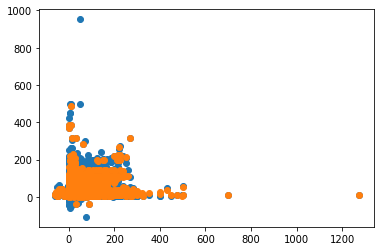

In [47]:
import matplotlib.pyplot as plt
plt.scatter(y_test,y1)
plt.scatter(y_test,y2)